In [1]:
import numpy as np
import pandas as pd

import os
from collections import Counter

import scanpy as sc


import matplotlib.pyplot as plt
import seaborn as sns
import statannot


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap

import muon


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2024-07-20 15:11:35.119013: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 15:11:35.122354: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 15:11:35.168092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 15:11:35.904246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa

# Prepare Data

In [3]:
data_dir = "../../data/Using/"
os.listdir(data_dir)


['sample.csv', 'log.txt', 'metab.csv', 'lipid.csv']

In [4]:
obs=pd.read_csv(os.path.join(data_dir,"sample.csv"),index_col=0)
obs

,Unnamed: 0,hospital_id,Name,batch,os,oss,type,TMN,主要分型,次要分型,...,rfss,CODEX主要亚型,克隆,MT2结构,pTNMs,生存时间,状态,生存时间分组,ascl1,codex_new
Sample Name,,,,,,,,,,,,,,,,,,,,,
1520,0.0,305980,张文东,1.0,140.670000,1.0,Y,I,A,Y,...,0.0,A,2.0,high,I,140.666667,1.0,LTS,27.387988,N
2423,1.0,337236,章立球,1.0,90.330000,1.0,N,I,A,NaN,...,0.0,A,1.0,low,I,90.333333,1.0,LTS,74.232005,A
3334,2.0,379551,高秀芬,1.0,80.970000,1.0,Y,III,A,NaN,...,1.0,A,1.0,low,III,80.966667,1.0,LTS,71.903618,A
1277,3.0,297125,朱桂林,1.0,86.430000,0.0,P,II,P,NaN,...,1.0,Neg,NaN,high,II,86.433333,0.0,LTS,NaN,NaN
4931,4.0,472789,刘经江,1.0,58.730000,0.0,N,I,A,N,...,0.0,A,2.0,high,I,58.733333,0.0,LTS,69.037432,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,589950,NaN,NaN,1.100000,0.0,NaN,NaN,NaN,NaN,...,NaN,A,2.0,low,I,1.100000,0.0,NaN,31.929713,NaN
NaN,NaN,596795,NaN,NaN,48.733333,0.0,NaN,NaN,NaN,NaN,...,NaN,A,2.0,low,III,48.733333,0.0,LTS,82.393520,NaN
NaN,NaN,605383,NaN,NaN,15.100000,1.0,NaN,NaN,NaN,NaN,...,NaN,N,2.0,low,II,15.100000,1.0,NaN,6.595716,NaN


In [5]:
views=["lipid"]
mods = {i:sc.AnnData(pd.read_csv(f"{data_dir}/{i}.csv", index_col=0)) for i in tuple(views)}


X converted to numpy array with dtype float64


In [6]:
mods

{'lipid': AnnData object with n_obs × n_vars = 106 × 750}

In [7]:
mdata=mu.MuData(mods)
mdata.obs=mdata.obs.join(obs)

In [21]:
mdata.obs

,Unnamed: 0,hospital_id,Name,batch,os,oss,type,TMN,主要分型,次要分型,...,rfss,CODEX主要亚型,克隆,MT2结构,pTNMs,生存时间,状态,生存时间分组,ascl1,codex_new
1452,13.0,304077.0,廖湘云,1.0,33.13,1.0,N,II,A,NaN,...,0.0,A,2.0,low,II,33.133333,1.0,NaN,38.713112,Y
8339,35.0,649485.0,谷良同,1.0,9.20,1.0,N,I,A,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,STS,NaN,NaN
5608,26.0,504897.0,蔡德胜,1.0,54.37,1.0,A,III,A,N,...,1.0,A,2.0,low,III,54.366667,1.0,LTS,77.695772,A
8232,34.0,643466.0,张德义,1.0,35.97,0.0,P,II,V,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8775,36.0,2030451.0,郭淑平,1.0,27.73,0.0,A,III,A,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8855,56.0,2036079.0,王秉全,1.0,22.00,0.0,N,II,A,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8195,19.0,640948.0,王谋年,1.0,14.77,1.0,P,III,A,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2236,7.0,330196.0,郭卫春,1.0,117.83,0.0,P,III,Y,NaN,...,0.0,Y,1.0,low,III,117.833333,0.0,LTS,0.078047,N
173161-T,64.0,248795.0,顾美英,2.0,11.53,1.0,A,III,A,NaN,...,1.0,A,1.0,low,III,11.533333,1.0,STS,77.334260,A


# Integrate

In [9]:
output_dirpath="./models/lipid_only/"
os.makedirs(output_dirpath,exist_ok=True)

In [10]:
mu.tl.mofa(mdata,use_obs='intersection',n_factors=15,
           convergence_mode='medium',
           outfile=os.path.join(output_dirpath,"CLL_intersection.hdf5"))


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded view='lipid' group='group1' with N=106 samples and D=750 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (lipid): gaussian




######################################
## Training the model with seed 1 ##
######################################



Converged!



#######################
## Training finished ##
#######################


Saving model in ./models/lipid_only/CLL_intersection.hdf5...
Saved MOFA embeddings in .obsm['X_mofa'] slot and their loadings in .varm['LFs'].


In [11]:
mu.tl.mofa(mdata,use_obs='union',n_factors=15,
           convergence_mode='medium',
           outfile=os.path.join(output_dirpath,"CLL_union.hdf5"))


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='lipid' group='group1' with N=106 samples and D=750 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (lipid): gaussian




#############################

# Interpret

## Model

In [48]:
# model = mofa.mofa_model("./models/CLL_union.hdf5")
model = mofa.mofa_model("./models/CLL_intersection.hdf5")
model

MOFA+ model: CLL intersection
Samples (cells): 101
Features: 921
Groups: group1 (101)
Views: lipid (750), metab (171)
Factors: 15
Expectations: W, Z

In [64]:
print(f"""\
Cells: {model.shape[0]}
Features: {model.shape[1]}
Groups of cells: {', '.join(model.groups)}
Views: {', '.join(model.views)}
""")

Cells: 101
Features: 921
Groups of cells: group1
Views: metab, lipid



In [84]:
model.get_factors()

array([[-1.9232627 ,  0.28729265, -5.12154631, ...,  0.27606332,
         5.12433403,  3.18286716],
       [ 4.74272552, -4.27336664, -3.66030341, ...,  2.48394809,
        -2.41122366,  2.30075545],
       [-5.42796315,  1.84389655, -1.16032285, ..., -1.52820977,
        -2.10690818,  1.82759593],
       ...,
       [ 3.18677669, -2.19233167,  0.40200223, ..., -0.78251687,
        -4.19745542, -0.17960355],
       [ 0.14571482, -1.2326068 , -1.92572364, ...,  1.62042402,
        -3.89678551, -2.58636435],
       [ 2.0492888 , -3.3357841 ,  3.73193412, ...,  1.30914545,
         0.26666405, -1.89351628]])

In [65]:
display(model.get_weights(df=True))

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
2-aminooctanoic acid,-1.934992e+03,-3.556995e+04,1.992382e+03,2.350576e+05,-7.642789e+02,-1.278189e+04,-3.201196e+03,1.558096e+03,8.416837e+03,4.840423e+03,4.309499e+04,3.504670e+03,7.007797e+03,5.680843e+03,-2.823935e+04
2-deoxyglucose-6-phosphate,1.851255e+00,1.595848e+01,1.233523e+00,-1.287580e+01,8.405187e-01,-7.780949e-01,3.400024e+00,2.625743e-01,6.111460e+00,3.145463e+00,-2.319278e+00,-8.336539e-01,1.249013e+00,-4.267175e+00,4.420508e+00
2-hydroxy-2-methylbutanedioic acid,8.266127e+01,9.264988e+03,-5.927621e+02,1.774766e+02,1.635457e+01,-4.619234e+01,-1.338189e+02,-1.676381e+02,3.805075e+01,1.910075e+02,-2.198919e+02,-1.033202e+02,3.408379e+02,1.581814e+03,-8.695146e+02
2-hydroxygluterate,-1.911317e+02,9.184613e+03,-4.143973e+03,8.628308e+02,8.746335e+02,-3.449862e+01,8.545167e+02,4.068812e+02,1.421465e+02,4.356833e+01,-1.474179e+03,-4.047868e+03,-1.675595e+02,2.595104e+02,-8.563032e+04
2-isopropylmalic acid,-1.144961e+04,-3.021346e+05,-1.069494e+04,1.644742e+05,1.297807e+05,-1.181615e+05,6.701945e+05,3.783159e+05,1.828632e+05,-1.687639e+05,4.174825e+04,1.394141e+04,-1.184175e+05,-5.954392e+04,-9.545950e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TG(18:2_20:4_22:6),4.605189e+08,6.169603e+08,-3.282933e+08,3.800128e+06,-1.766583e+07,2.221868e+06,-1.730320e+07,1.110789e+08,-3.088655e+06,-1.297989e+08,8.699132e+07,-8.697856e+06,-9.957914e+05,8.744947e+07,-2.207753e+07
TG(20:4_20:4_22:6),2.894689e+08,4.067736e+08,-1.960843e+08,1.747712e+06,-4.415688e+06,1.999790e+06,-5.989646e+07,1.063731e+08,-3.318238e+05,-2.703441e+07,4.809614e+07,3.245304e+06,1.969699e+06,1.425854e+08,-9.215029e+06
TG(22:4_22:4_22:4),3.413579e+04,5.391891e+03,-1.955827e+05,2.028742e+04,-4.009530e+04,6.605164e+04,-4.645743e+04,-4.238927e+04,4.057547e+04,-4.421403e+05,4.157739e+03,-3.728324e+06,-1.874877e+06,-3.808096e+05,4.117504e+04
TG(8:0_8:0_10:0),2.961069e+04,-5.277822e+04,1.396968e+05,1.118268e+06,-2.503017e+03,-1.359973e+06,2.958597e+04,-3.484258e+04,-2.964259e+04,3.338160e+05,1.244499e+04,-2.404505e+04,2.513030e+04,2.412999e+04,-5.452622e+04


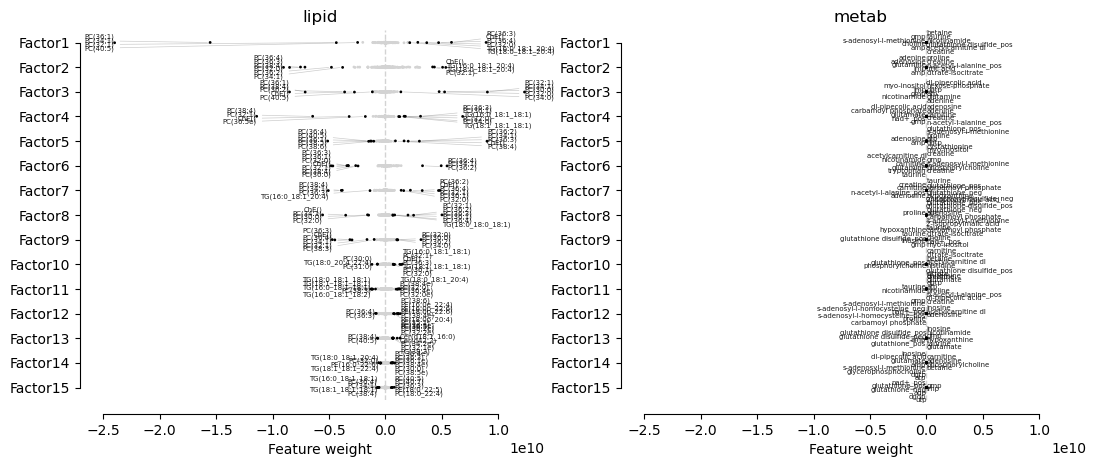

In [68]:
ax = mofa.plot_weights(model, factor=1, n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)

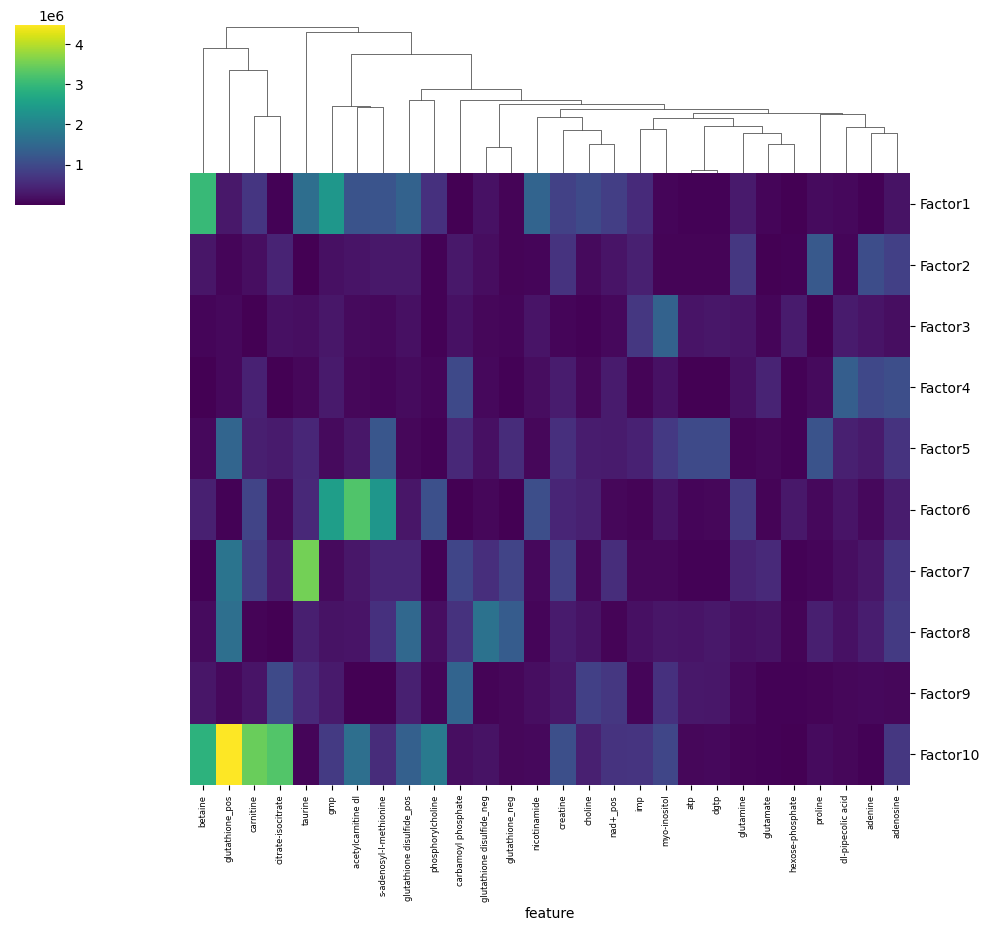

In [69]:
mofa.plot_weights_heatmap(model, n_features=5, 
                         factors=range(0, 10), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)

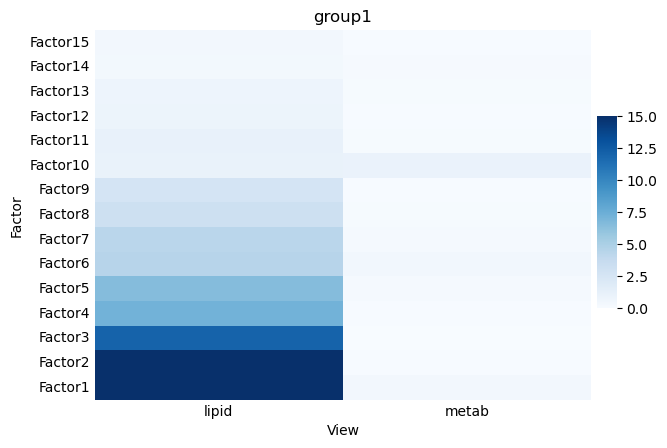

In [49]:
mofa.plot_r2(model,x='View',vmax=15)

<Axes: title={'center': 'metab'}, xlabel='Feature weight'>

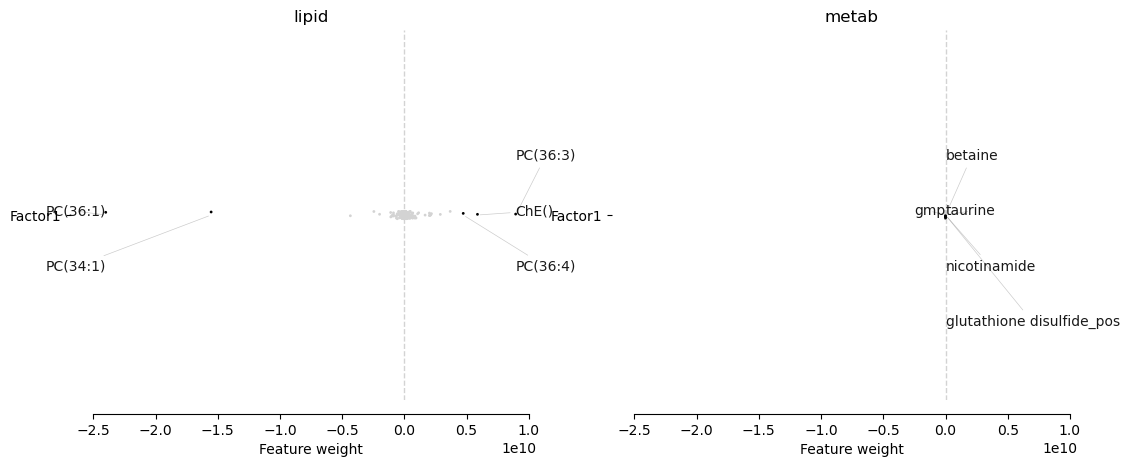

In [50]:
mofa.plot_weights(model, views=views, factors=0, zero_line=True, ncols=2, label_size=10)


## Metadata

In [51]:
model.metadata

,group,CODEX主要亚型,MT2结构,Name,RNAseq分型,TMN,Unnamed: 0,ascl1,batch,codex_new,...,rfss,type,主要分型,克隆,尝试分型,次要分型,状态,生存时间,生存时间分组,转录组分型
sample,,,,,,,,,,,,,,,,,,,,,
120136-T,group1,nan,nan,龚希坤,A,III,61.0,NaN,2.0,nan,...,0.0,A,nan,NaN,A,nan,NaN,NaN,STS,nan
120155-T,group1,Neg,high,唐国芬,N,I,68.0,NaN,2.0,nan,...,0.0,N,0,NaN,N,nan,0.0,131.533333,LTS,nan
120342-T,group1,N,low,李超成,N,I,69.0,1.315999,2.0,N,...,0.0,N,A,2.0,A,N,0.0,126.233333,LTS,nan
120367-T,group1,A,low,黄才元,N,III,70.0,64.002994,2.0,A,...,1.0,N,A,2.0,N,N,1.0,29.833333,nan,nan
120412-T,group1,nan,nan,方国源,P,III,71.0,NaN,2.0,nan,...,1.0,P,nan,NaN,P,nan,NaN,NaN,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8418,group1,nan,nan,许志强,P,I,49.0,NaN,1.0,nan,...,0.0,P,A,NaN,A,nan,NaN,NaN,nan,Cluster2
8575,group1,nan,nan,李胜利,N,III,50.0,NaN,1.0,nan,...,0.0,N,0,NaN,N,nan,NaN,NaN,nan,N
8711,group1,nan,nan,盛永发,Y,I,55.0,NaN,1.0,nan,...,0.0,Y,A,NaN,A,nan,NaN,NaN,nan,I


In [76]:
model.metadata.TMN

sample
120136-T    III
120155-T      I
120342-T      I
120367-T    III
120412-T    III
           ... 
8418          I
8575        III
8711          I
8775        III
8816          I
Name: TMN, Length: 101, dtype: object

In [78]:
model.metadata.TMN=model.metadata.TMN.astype('category')

TypeError: functools.partial(<function scatterplot at 0x7f463a490a60>, s=20) got multiple values for keyword argument 'hue'

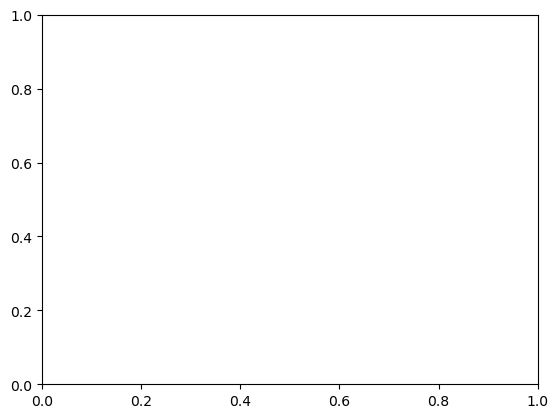

In [79]:
mofa.plot_factors(model,factors=list(range(5)), alpha=.1,
                 group_label="TMN", hue="TMN")

In [60]:
# model.metadata.trisomy12 = (
#     model.metadata['生存时间分组'].astype(str).
#         replace({'1.0': 'trisomy12', '0.0': 'no trisomy12', 'nan': 'NA'}).
#         astype('category').cat.reorder_categories(['trisomy12', 'no trisomy12', 'NA'])
# )
model.metadata.survival_group = (
    model.metadata['生存时间分组'].astype(str).
            replace({'nan': 'NA'}).
        astype('category')
)
model.metadata.survival_group

sample
120136-T    STS
120155-T    LTS
120342-T    LTS
120367-T     NA
120412-T     NA
           ... 
8418         NA
8575         NA
8711         NA
8775         NA
8816         NA
Name: 生存时间分组, Length: 101, dtype: category
Categories (3, object): ['LTS', 'NA', 'STS']

In [61]:
mdata.survival_group = (
    model.metadata['生存时间分组'].astype(str).
            replace({'nan': 'NA'}).
        astype('category')
)

AttributeError: PolyCollection.set() got an unexpected keyword argument 's'

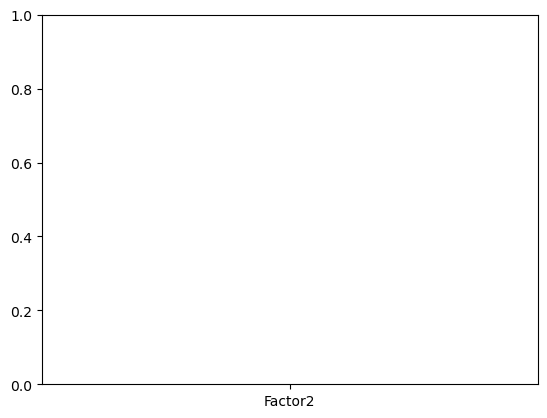

In [70]:
mofa.plot_factors_violin(model, factors=1, violins=True, violins_alpha=.3, dots=True, color="batch", palette="Set2")

In [ ]:
mofa.plot_factors_violin(model, factors=1, violins=True, violins_alpha=.3, dots=True, color="survival_group", palette="Set2")

AssertionError: Requested features are not found